In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import itertools
import time

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import spatial
import tensorflow as tf
import keras
import pandas as pd
import math
SEED = 1
np.random.seed(SEED)
# tf.set_random_seed(SEED)

Using TensorFlow backend.


## Import data

In [2]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\brizio\Documents\PythonNB\FICOchallenge


In [3]:
X1 = pd.read_csv('./Data/encoded_data.csv')
y = pd.read_csv('./Data/y_data.csv')

In [4]:
from sklearn.model_selection import cross_val_score, train_test_split

# One-hot
# data_onehot = pd.get_dummies(data)
X_onehot = pd.get_dummies(X1)
y_onehot = pd.get_dummies(y["RiskPerformance"])[['Bad']]
print(np.array(np.unique(y_onehot, return_counts=True)).T)

X_train, X_test, y_train, y_test, X_onehot_train, X_onehot_test, y_onehot_train, y_onehot_test, = \
train_test_split(X1, y, X_onehot, y_onehot, test_size = .25, random_state = 2020, shuffle = True)
print(X_onehot_train.shape, X_onehot_test.shape, y_onehot_train.shape, y_onehot_test.shape)

[[   0 5000]
 [   1 5459]]
(7844, 145) (2615, 145) (7844, 1) (2615, 1)


## Import Model

In [5]:
# Model Creation
from keras.models import Sequential, Model 
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPool1D, Flatten, Input, concatenate, Dropout, Activation
import keras.backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


def get_FFNN_model(X, y, hidden_layers_size = [4]):
    """
        BASIC MODEL for the FF-NN
    """
    input_size = len(X.columns.values)
    output_size = len(y.columns.values)
    
    if len(hidden_layers_size) == 0:
        # No hidden layer (linear regression equivalent)
        ff_layers = [ Dense(output_size, input_shape=(input_size,), activation='softmax') ]
    else:
        # With sigmoid hidden layers        
        ff_layers = [
            Dense(hidden_layers_size[0], input_shape=(input_size,), activation='relu'),
#             tf.keras.layers.Dense(20, input_shape=(input_size,), activation='sigmoid'),
#             Activation('relu'),
            Dense(output_size, activation='sigmoid') 
        ]
#         for hidden_size in hidden_layers_size[1:]:  
#             ff_layers.insert( -1,  Dense(hidden_size, activation='tanh') )
#             ff_layers.insert( -1,  Activation('relu') )
            
            
    print(ff_layers)
    model = Sequential(ff_layers)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy',recall_m,precision_m])
    model.summary()
    return model

In [6]:
# Model Training
from keras.callbacks import ModelCheckpoint, EarlyStopping

EPOCHS = 30
PATIENCE = 8
BATCH_SIZE = 8

def net_train(model, bestmodel_path, X_train, y_train_onehot, X_validate, y_validate_onehot, epochs = EPOCHS):
    # Define four callbacks to use
    checkpointer = keras.callbacks.ModelCheckpoint(filepath = bestmodel_path, verbose = 1, save_best_only = True)
    early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = PATIENCE)

    # Train the model
    history = model.fit(X_onehot_train, y_train_onehot, verbose = 2, epochs=epochs, batch_size=BATCH_SIZE, callbacks=[checkpointer
                                                                                                                      , early_stopping
                                                                                                                     ], validation_data=(X_validate, y_validate_onehot))

    return history

In [7]:
import matplotlib.pyplot as plt
RESULT_PATH = './results'
HIDDEN_LAYERS = [10]

model = get_FFNN_model(X_onehot, y_onehot, HIDDEN_LAYERS)

model_path = os.path.join(RESULT_PATH, 'net_145.h5')
forge_gen = False

if not os.path.exists(model_path) or forge_gen:
    history = net_train(model, model_path, X_onehot_train, y_onehot_train, X_onehot_test, y_onehot_test)    
    
    score = model.evaluate(X_onehot_test, y_onehot_test)
    plt.figure(figsize=(14,6))
    for key in history.history.keys():
        plt.plot(history.history[key], label=key)
    plt.legend(loc='best')
    plt.grid(alpha=.2)
    plt.title(f'batch_size = {BATCH_SIZE}, epochs = {EPOCHS}')
    plt.draw()
else:
    print('Model loaded.')
    model.load_weights(model_path);


[<keras.layers.core.Dense object at 0x00000177914E4988>, <keras.layers.core.Dense object at 0x00000177914E4D08>]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                1460      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,471
Trainable params: 1,471
Non-trainable params: 0
_________________________________________________________________
Model loaded.








In [8]:
import networkx as nx
import random

    
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

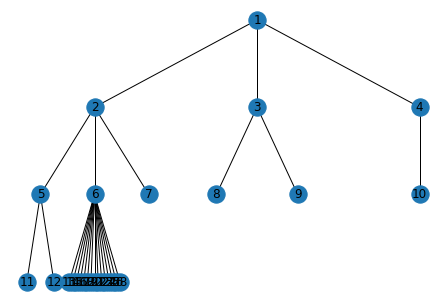

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
G_ex=nx.Graph()
G_ex.add_edges_from([(1,2), (1,3), (1,4), (2,5), (2,6), (2,7), (3,8), (3,9), (4,10),
                  (5,11), (5,12), (6,13), (6,14), (6,15), (6,16), (6,17), (6,18), (6,19), (6,20),
                  (6,21), (6,22), (6,23), (6,24), (6,25), (6,26), (6,28)])
pos = hierarchy_pos(G_ex,1)    
pos
nx.draw(G_ex, pos=pos, with_labels=True)
# plt.savefig('hierarchy.png')

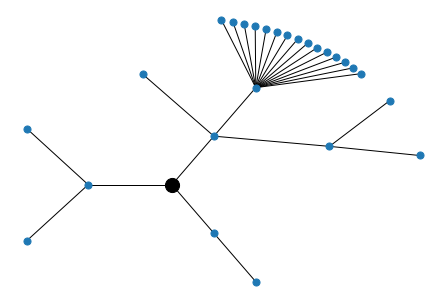

In [10]:
pos = hierarchy_pos(G_ex, 1, width = 2*math.pi, xcenter=0)
# print(pos)
new_pos = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}
# print('n',new_pos)
nx.draw(G_ex, pos=new_pos, node_size = 50)
nx.draw_networkx_nodes(G_ex, pos=new_pos, nodelist = [1], node_color = 'black', node_size = 200)

In [11]:
debug = False
def generate_featprime(feature_acts):
    feature_acts_primes = []
    for i in range(len(feature_acts)):
        feature_acts_prime = feature_acts.copy()
        feature_acts_prime[i] = 0
        feature_acts_primes.append(feature_acts_prime)
    return np.array(feature_acts_primes)

def generate_af_counterfactual(idx, strong = True):
#     x = X_test.iloc[idx]
    x_onehot = X_onehot_test.loc[idx].values
    prob = model.predict(np.array([x_onehot]))[0][0] 
    class_idx = (prob > .5) * 1
    class_name = class_names[class_idx]
    feature_acts = features_func([np.array([x_onehot])])[0][0]
    relevance_current_class = get_feature_to_output_relevance(x_onehot)
#     print(relevance_current_class)
    
    G = nx.DiGraph()
    class_node = f'{CLASS}\n{class_name}'
    G.add_node(class_node, level = 2, relevance = relevance_current_class.sum(), label = CLASS + ' = ' + class_name + "\n (prob = %.1f%%)" % (prob*100))
    
    feature_acts_prime = generate_featprime(feature_acts)
    pre_soft_prime = feature_extraction_model.predict(feature_acts_prime)
    critical_supports_feature = ((pre_soft_prime > .5) * 1).flatten() != class_idx
    
#     X_primes = generate_Xprime(x)
    
    for filter_idx in range(len(feature_acts)):
        if critical_supports_feature[filter_idx]:
            G.add_node(filter_idx, type = CRITICAL_SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]), level = 1, label = 'Hidden Neuron ' + str(filter_idx)+ "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(filter_idx, class_node, type = CRITICAL_SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]), level = 1)
        elif relevance_current_class[filter_idx] > 0:
            G.add_node(filter_idx, type = SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]), level = 1, label = 'Hidden Neuron ' + str(filter_idx) + "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(filter_idx, class_node, type = SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]), level = 1)
        elif relevance_current_class[filter_idx] < 0:
            G.add_node(filter_idx, type = ATTACK, relevance = np.abs(relevance_current_class[filter_idx]), level = 1, label = 'Hidden Neuron ' + str(filter_idx)+ "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(filter_idx, class_node, type = ATTACK, relevance = np.abs(relevance_current_class[filter_idx]), level = 1)
#         elif relevance_current_class[filter_idx] == 0:
#             G.add_node(filter_idx, relevance = np.abs(relevance_current_class[filter_idx]), level = 1)
#             G.add_edge(filter_idx, class_node, type = NEUTRAL, level = 1)
        
    input_relevance = np.array(get_input_to_feature_relevance(x_onehot))
    
    for filter_idx in [node for node in G.nodes if G.nodes[node]['level'] == 1]:
        for c, col in enumerate(X_onehot.columns.values):
            label = f"{'_'.join(col.split('_')[:-1])} = {col.split('_')[-1]}"
#             val = denseW[c,filter_idx] / denseW[:,filter_idx].sum() * np.abs(relevance_current_class[filter_idx])
            val = input_relevance[c,filter_idx] / np.abs(input_relevance[:,filter_idx]).sum()
            if input_relevance[c,filter_idx] > 0 and x_onehot[c] > 0:
                if debug:
                    print(filter_idx,col,SUPPORT,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
                G.add_node((filter_idx, col),             type = SUPPORT, level = 0, relevance = np.abs( input_relevance[c,filter_idx]), label = label)
                G.add_edge((filter_idx, col), filter_idx, type = SUPPORT, level = 0, relevance = np.abs( input_relevance[c,filter_idx]), label = label)
            elif input_relevance[c,filter_idx] < 0 and x_onehot[c] > 0:
                if debug:
                    print(filter_idx,col,ATTACK,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
                G.add_node((filter_idx, col),             type = ATTACK, level = 0, relevance = np.abs( input_relevance[c,filter_idx]), label = label)
                G.add_edge((filter_idx, col), filter_idx, type = ATTACK, level = 0, relevance = np.abs( input_relevance[c,filter_idx]), label = label)
            elif input_relevance[c,filter_idx] > 0:
                if debug:
                    print(filter_idx,col,NON_SUPPORT,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
                G.add_node((filter_idx, col),             type = NON_SUPPORT, level = 0, relevance = np.abs( input_relevance[c,filter_idx]), label = label)
                G.add_edge((filter_idx, col), filter_idx, type = NON_SUPPORT, level = 0, relevance = np.abs( input_relevance[c,filter_idx]), label = label)
            elif input_relevance[c,filter_idx] < 0:
                if debug:
                    print(filter_idx,col,NON_ATTACK,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
                G.add_node((filter_idx, col),             type = NON_ATTACK, level = 0, relevance = np.abs( input_relevance[c,filter_idx]), label = label)
                G.add_edge((filter_idx, col), filter_idx, type = NON_ATTACK, level = 0, relevance = np.abs( input_relevance[c,filter_idx]), label = label)

    for c, col in enumerate(X_onehot.columns.values):
        if x_onehot[c] > 0:
            x_onehot_prime = x_onehot.copy()
            x_onehot_prime[c] = 0
            feature_acts_prime = features_func([np.array([x_onehot_prime])])[0][0]

            for filter_idx in [node for node in G.nodes if G.nodes[node]['level'] == 1]:
                if feature_acts[filter_idx] > 0 and feature_acts_prime[filter_idx] <= 0:
                    G.nodes[(filter_idx, col)]['type'] = CRITICAL_SUPPORT
                    G.edges[((filter_idx, col), filter_idx)]['type'] = CRITICAL_SUPPORT
    return G

In [12]:
import innvestigate
from pylab import *

ATTACK = '-'
SUPPORT = '+'
NEUTRAL = '0'
NON_SUPPORT = '+~'
NON_ATTACK = '-~'
CRITICAL_ATTACK = '-!'
CRITICAL_SUPPORT = '+!'
RELATIONS = [SUPPORT, ATTACK, NEUTRAL, CRITICAL_SUPPORT, CRITICAL_ATTACK]

COLORS = {
    ATTACK: plt.get_cmap("tab20b")([13])[0],
    SUPPORT: plt.get_cmap("tab20c")([9])[0],
    CRITICAL_ATTACK: plt.get_cmap("tab20b")([13])[0],
    CRITICAL_SUPPORT: plt.get_cmap("tab20")([0])[0],
    NEUTRAL: plt.get_cmap("tab20c")([18])[0],
    NON_SUPPORT: plt.get_cmap("tab20c")([11])[0],
    NON_ATTACK: plt.get_cmap("tab20b")([15])[0],
}

CLASS = 'RiskPerformance'
lrp_type = 'lrp.epsilon'
intermediate_layer_idx = 0
features_func = K.function([model.layers[0].input],[model.layers[intermediate_layer_idx].output])
class_names = sorted(y[CLASS].unique(),  reverse=True)

def num_all_filters():
    return HIDDEN_LAYERS[0]

def create_intermediate_to_output_model(model, intermediate_layer_idx):
    newinput = x = keras.layers.Input(shape=K.int_shape(model.layers[intermediate_layer_idx].output)[1:])
    for layer in model.layers[intermediate_layer_idx+1:]:
        x = layer(x)
    return keras.Model(inputs=[newinput],outputs=[x])

feature_extraction_model = create_intermediate_to_output_model(model, intermediate_layer_idx)
feature_relevance_analyzer = innvestigate.create_analyzer(lrp_type, feature_extraction_model, neuron_selection_mode="index")

def get_feature_to_output_relevance(x_onehot):
    return feature_relevance_analyzer.analyze(features_func([np.array([x_onehot])])[0], 0)[0]

def create_input_to_intermediate_model(model, intermediate_layer_idx):
    return keras.Model(inputs=[model.input],outputs=[model.layers[intermediate_layer_idx].output])

input_extraction_model = create_input_to_intermediate_model(model, intermediate_layer_idx)
input_relevance_analyzer = innvestigate.create_analyzer(lrp_type, input_extraction_model, neuron_selection_mode="index")

def get_input_to_feature_relevance(x_onehot):
    input_relevance = []
    for filter_idx in range(num_all_filters()):
        input_relevance.append( np.expand_dims(input_relevance_analyzer.analyze(np.array([x_onehot]), filter_idx)[0], axis = -1) )
    return np.concatenate(input_relevance, axis = -1)


G = generate_af_counterfactual(131, strong = True)

In [13]:
G

In [14]:
idx = 131
x_onehot = X_onehot_test.loc[idx].values
print(X_test.loc[idx])
prob = model.predict(np.array([x_onehot]))[0][0] 
class_idx = (prob > .5) * 1
class_name = class_names[class_idx]
feature_acts = features_func([np.array([x_onehot])])[0][0]
relevance_current_class = get_feature_to_output_relevance(x_onehot)
G = nx.DiGraph()
class_node = f'{CLASS}\n{class_name}'
G.add_node(class_node,  relevance = relevance_current_class.sum(), label = CLASS + ' = ' + class_name + "\n (prob = %.1f%%)" % (prob*100))
feature_acts_prime = generate_featprime(feature_acts)
pre_soft_prime = feature_extraction_model.predict(feature_acts_prime)
critical_supports_feature = ((pre_soft_prime > .5) * 1).flatten() != class_idx

ExternalRiskEstimate_bin                    (0.0, 63.0]
MSinceOldestTradeOpen_bin                 (91.0, 134.0]
MSinceMostRecentTradeOpen_bin               (0.0, 19.0]
AverageMInFile_bin                         (69.0, 96.0]
NumSatisfactoryTrades_bin                  (12.0, 21.0]
NumTrades60Ever2DerogPubRec_bin              (0.0, 1.0]
NumTrades90Ever2DerogPubRec_bin             (-7.0, 0.0]
NumTotalTrades_bin                         (16.0, 27.0]
NumTradesOpeninLast12M_bin                   (0.0, 2.0]
PercentTradesNeverDelq_bin                 (59.0, 84.0]
MSinceMostRecentDelq_bin                    (0.0, 17.0]
MaxDelq2PublicRecLast12M_bin                 (0.0, 5.0]
MaxDelqEver_bin                              (2.0, inf]
PercentInstallTrades_bin                   (46.0, 57.0]
NetFractionInstallBurden_bin               (-9.0, -8.0]
NumInstallTradesWBalance_bin                 (0.0, 2.0]
MSinceMostRecentInqexcl7days_bin           (-8.0, -7.0]
NumInqLast6M_bin                             (1.

In [15]:
for filter_idx in range(len(feature_acts)):
        if critical_supports_feature[filter_idx]:
            G.add_node(filter_idx, type = CRITICAL_SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]),  label = 'Hidden Neuron ' + str(filter_idx)+ "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(class_node, filter_idx,  type = CRITICAL_SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]))
        elif relevance_current_class[filter_idx] > 0:
            G.add_node(filter_idx, type = SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]), label = 'Hidden Neuron ' + str(filter_idx) + "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(class_node, filter_idx, type = SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]))
        elif relevance_current_class[filter_idx] < 0:
            G.add_node(filter_idx,  type = ATTACK, relevance = np.abs(relevance_current_class[filter_idx]),  label = 'Hidden Neuron ' + str(filter_idx)+ "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(class_node, filter_idx, type = ATTACK, relevance = np.abs(relevance_current_class[filter_idx]))
#         elif relevance_current_class[filter_idx] == 0:
#             G.add_node(filter_idx, relevance = np.abs(relevance_current_class[filter_idx]), level = 1)
#             G.add_edge(filter_idx, class_node, type = NEUTRAL, level = 1)
input_relevance = np.array(get_input_to_feature_relevance(x_onehot))


In [16]:
debug = False
for filter_idx in [node for node in G.nodes if G.nodes[node]][1:]:
    for c, col in enumerate(X_onehot.columns.values):
        label = f"{'_'.join(col.split('_')[:-1])} = {col.split('_')[-1]}"
        val = input_relevance[c,filter_idx] / np.abs(input_relevance[:,filter_idx]).sum()
        if input_relevance[c,filter_idx] > 0 and x_onehot[c] > 0:
            if debug:
                print(filter_idx,col,SUPPORT,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node((filter_idx,col) 
                       ,           type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx, (filter_idx,col)
                       , type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
        elif input_relevance[c,filter_idx] < 0 and x_onehot[c] > 0:
            if debug:
                print(filter_idx,col,ATTACK,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node((filter_idx,col)
                       ,           type = ATTACK, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx, (filter_idx,col)
                       , type = ATTACK, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
        elif input_relevance[c,filter_idx] > 0:
            if debug:
                print(filter_idx,col,NON_SUPPORT,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node((filter_idx,col)
                       ,           type = NON_SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx, (filter_idx,col)
                       , type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
        elif input_relevance[c,filter_idx] < 0:
            if debug:
                print(filter_idx,col,NON_ATTACK,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node((filter_idx,col)
                       ,           type = NON_ATTACK, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx, (filter_idx,col)
                       , type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )

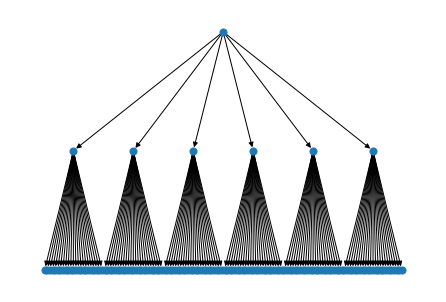

In [17]:
pos = hierarchy_pos(G)    
nx.draw(G, pos=pos, with_labels=False, node_size = 50)

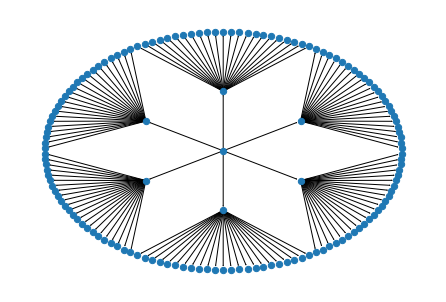

In [18]:
pos = hierarchy_pos(G, width = 2*math.pi, xcenter=0)
new_pos = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}
nx.draw(G, pos=new_pos, with_labels=False, node_size = 40, arrowsize=0.5)
# nx.draw_networkx_nodes(G_ex, pos=new_pos, nodelist = ['RiskPerformance\nGood'], node_color = 'red', node_size = 100, with_labels=True);

C:\Users\brizio\Anaconda3\envs\gnet\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


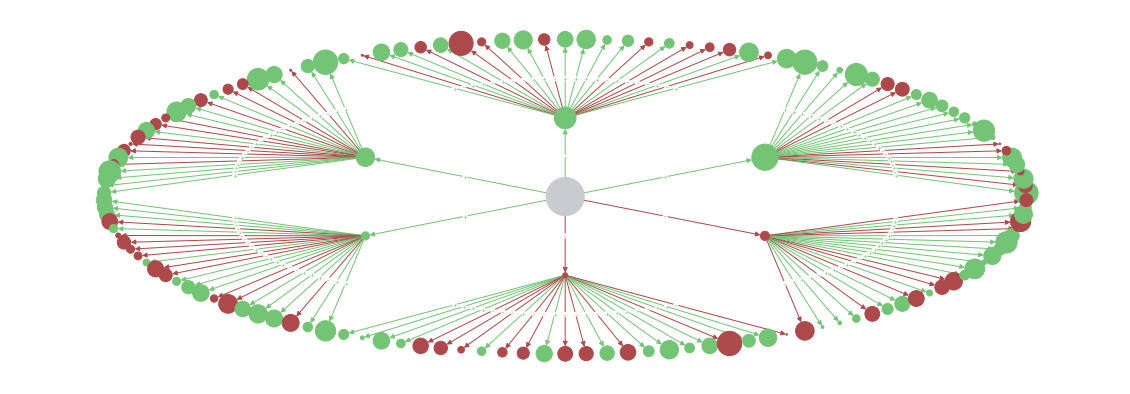

In [19]:
FONT_SIZE = 6
labels_plot = False
font_color = 'black'
layout = new_pos
node_shape = 'o'
node_color = ['#%02x%02x%02x' % (200, 204, 208)]+[COLORS[G.edges[edge]['type']] for edge in G.edges]
node_strengths = [G.nodes[node]['relevance'] for node in G.nodes]
node_size = 30000*np.abs(node_strengths) / np.sum(np.abs(node_strengths))
node_labels = {node: str(node) if 'label' not in G.nodes[node] else G.nodes[node]['label'] for node in G.nodes}

edge_color = [COLORS[G.edges[edge]['type']] for edge in G.edges]
edge_labels = [G.edges[edge]['type'] for edge in G.edges]
edge_width = 1

plt.figure(figsize = (20, 7))
# Nodes
nx.draw_networkx_nodes(G, pos = layout, node_color = node_color, node_shape = node_shape, node_size = node_size)
# Labels
if labels_plot == True:
    nx.draw_networkx_labels(G, pos = layout, node_color = node_color, node_shape = node_shape, node_size = node_size, labels = node_labels, font_size = FONT_SIZE, font_color = font_color)
# Edges
nx.draw_networkx_edges(G, pos = layout, node_size = node_size, edge_color = edge_color, width = edge_width)
# Edges labels
for edge, edge_col, edge_lab in zip(list(G.edges), edge_color, edge_labels):
    nx.draw_networkx_edge_labels(G, pos = layout, edge_labels = {edge: edge_lab}, node_size = node_size, font_size = FONT_SIZE, font_color = edge_col, rotate = False, bbox = dict(boxstyle='circle,pad=0.01', ec=(1.0, 1.0, 1.0, 0.0),fc=(1.0, 1.0, 1.0, 1.0),))

plt.axis('off')
plt.show()

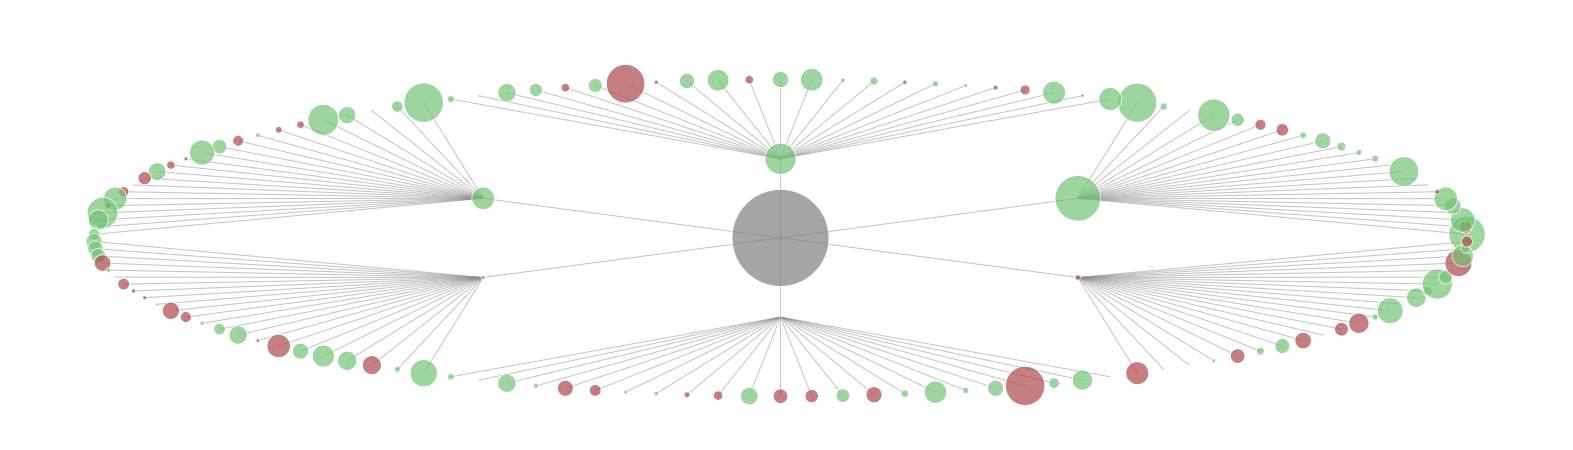

In [20]:
import plotly.graph_objects as go


edge_x = []
edge_y = []
for e, edge in enumerate(G.edges()):
    x0, y0 = layout[list(G.edges())[e][0]]
    x1, y1 = layout[list(G.edges())[e][1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for n, node in enumerate(G.nodes()):
    x, y = layout[list(G.nodes())[n]]
    node_x.append(x)
    node_y.append(y)

node_strengths = [G.nodes[node]['relevance'] for node in G.nodes]
node_size = 2000*np.abs(node_strengths) / np.sum(np.abs(node_strengths))
node_color = ['grey']+[matplotlib.colors.rgb2hex(COLORS[G.edges[edge]['type']]) for edge in G.edges]

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
#         showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
#         colorscale='YlGnBu',
#         reversescale=True,
        color=node_color,
        size=node_size,
#         colorbar=dict(
#             thickness=15,
#             title='Node Connections',
#             xanchor='left',
#             titleside='right'
#         ),
        line_width=1))

#### Adde labels
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(str(list(G.nodes)[node])+' : '+str([G.nodes[node]['relevance'] for node in G.nodes][node])
                     #'# of connections: '+str(len(adjacencies[1]))
                    )

# node_trace.marker.color = node_adjacencies
node_trace.text = node_text

#### Plot
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
#                 title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
#                 annotations=[ dict(
#                     text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
#                     showarrow=True,
#                     xref="paper", yref="paper",
#                     x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

ExternalRiskEstimate_bin                    (0.0, 63.0]
MSinceOldestTradeOpen_bin                 (91.0, 134.0]
MSinceMostRecentTradeOpen_bin               (0.0, 19.0]
AverageMInFile_bin                         (69.0, 96.0]
NumSatisfactoryTrades_bin                  (12.0, 21.0]
NumTrades60Ever2DerogPubRec_bin              (0.0, 1.0]
NumTrades90Ever2DerogPubRec_bin             (-7.0, 0.0]
NumTotalTrades_bin                         (16.0, 27.0]
NumTradesOpeninLast12M_bin                   (0.0, 2.0]
PercentTradesNeverDelq_bin                 (59.0, 84.0]
MSinceMostRecentDelq_bin                    (0.0, 17.0]
MaxDelq2PublicRecLast12M_bin                 (0.0, 5.0]
MaxDelqEver_bin                              (2.0, inf]
PercentInstallTrades_bin                   (46.0, 57.0]
NetFractionInstallBurden_bin               (-9.0, -8.0]
NumInstallTradesWBalance_bin                 (0.0, 2.0]
MSinceMostRecentInqexcl7days_bin           (-8.0, -7.0]
NumInqLast6M_bin                             (1.

C:\Users\brizio\Anaconda3\envs\gnet\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



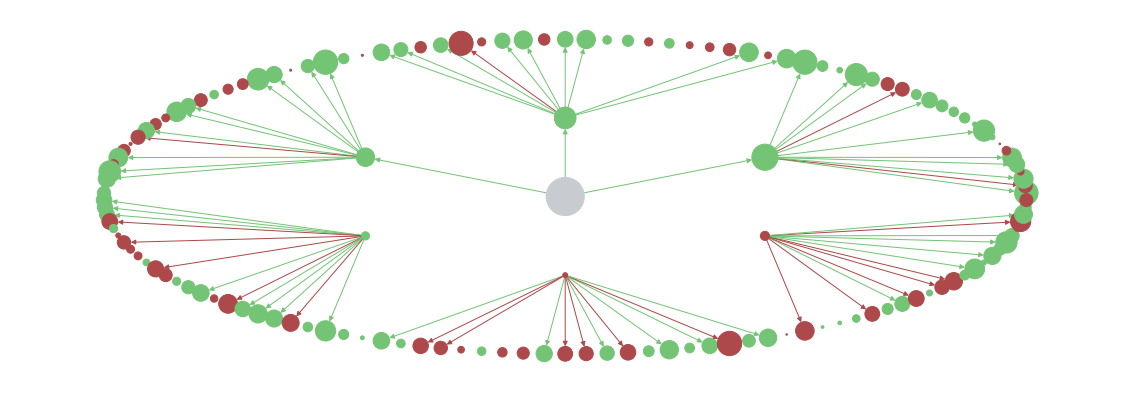

In [21]:
idx = 131
x_onehot = X_onehot_test.loc[idx].values
print(X_test.loc[idx])
prob = model.predict(np.array([x_onehot]))[0][0] 
class_idx = (prob > .5) * 1
class_name = class_names[class_idx]
feature_acts = features_func([np.array([x_onehot])])[0][0]
relevance_current_class = get_feature_to_output_relevance(x_onehot)
G = nx.DiGraph()
class_node = f'{CLASS}\n{class_name}'
G.add_node(class_node,  relevance = relevance_current_class.sum(), label = CLASS + ' = ' + class_name + "\n (prob = %.1f%%)" % (prob*100))
feature_acts_prime = generate_featprime(feature_acts)
pre_soft_prime = feature_extraction_model.predict(feature_acts_prime)
critical_supports_feature = ((pre_soft_prime > .5) * 1).flatten() != class_idx

for filter_idx in range(len(feature_acts)):
        if critical_supports_feature[filter_idx]:
            G.add_node(filter_idx, type = CRITICAL_SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]),  label = 'Hidden Neuron ' + str(filter_idx)+ "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(class_node, filter_idx,  type = CRITICAL_SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]))
        elif relevance_current_class[filter_idx] > 0:
            G.add_node(filter_idx, type = SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]), label = 'Hidden Neuron ' + str(filter_idx) + "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(class_node, filter_idx, type = SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]))
        elif relevance_current_class[filter_idx] < 0:
            G.add_node(filter_idx,  type = ATTACK, relevance = np.abs(relevance_current_class[filter_idx]),  label = 'Hidden Neuron ' + str(filter_idx)+ "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(class_node, filter_idx, type = ATTACK, relevance = np.abs(relevance_current_class[filter_idx]))
#         elif relevance_current_class[filter_idx] == 0:
#             G.add_node(filter_idx, relevance = np.abs(relevance_current_class[filter_idx]), level = 1)
#             G.add_edge(filter_idx, class_node, type = NEUTRAL, level = 1)
input_relevance = np.array(get_input_to_feature_relevance(x_onehot))

debug = False
for filter_idx in [node for node in G.nodes if G.nodes[node]][1:]:
    for c, col in enumerate(X_onehot.columns.values):
        label = f"{'_'.join(col.split('_')[:-1])} = {col.split('_')[-1]}"
        val = input_relevance[c,filter_idx] / np.abs(input_relevance[:,filter_idx]).sum()
        if input_relevance[c,filter_idx] > 0 and x_onehot[c] > 0:
            if debug:
                print(filter_idx,col,SUPPORT,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node((filter_idx,col) 
                       ,           type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx, (filter_idx,col)
                       , type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
        elif input_relevance[c,filter_idx] < 0 and x_onehot[c] > 0:
            if debug:
                print(filter_idx,col,ATTACK,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node((filter_idx,col)
                       ,           type = ATTACK, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx, (filter_idx,col)
                       , type = ATTACK, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
        elif input_relevance[c,filter_idx] > 0:
            if debug:
                print(filter_idx,col,NON_SUPPORT,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node((filter_idx,col)
                       ,           type = NON_SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx, (filter_idx,col)
                       , type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
        elif input_relevance[c,filter_idx] < 0:
            if debug:
                print(filter_idx,col,NON_ATTACK,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node((filter_idx,col)
                       ,           type = NON_ATTACK, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx, (filter_idx,col)
                       , type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["relevance"] > np.median([d["relevance"] for (u, v, d) in G.edges(data=True)])]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["relevance"] <= np.median([d["relevance"] for (u, v, d) in G.edges(data=True)])]
nlarge = [u for (u, v) in G.nodes(data=True) if v["relevance"] > np.median([d["relevance"] for (u, v, d) in G.edges(data=True)])]
nsmall = [u for (u, v) in G.nodes(data=True) if v["relevance"] <= np.median([d["relevance"] for (u, v, d) in G.edges(data=True)])]
print(len(elarge))
print(len(esmall))

# new_pos = nx.spring_layout(G)  # positions for all nodes

pos = hierarchy_pos(G, width = 2*math.pi, xcenter=0)
layout = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}

# nodes
FONT_SIZE = 8
labels_plot = False
font_color = 'black'
layout = new_pos
node_shape = 'o'
node_color = ['#%02x%02x%02x' % (200, 204, 208)]+[COLORS[G.edges[edge]['type']] for edge in G.edges]
node_strengths = [G.nodes[node]['relevance'] for node in G.nodes]
node_size = 30000*np.abs(node_strengths) / np.sum(np.abs(node_strengths))
node_labels = {node: str(node) if 'label' not in G.nodes[node] else G.nodes[node]['label'] for node in nlarge}

edge_color = [COLORS[G.edges[edge]['type']] for edge in G.edges if edge in elarge]
edge_labels = [G.edges[edge]['type'] for edge in G.edges]
edge_width = 1

plt.figure(figsize = (20, 7))
# Nodes
nx.draw_networkx_nodes(G, pos = layout, node_color = node_color, node_shape = node_shape, node_size = node_size)
# Labels
if labels_plot == True:
    nx.draw_networkx_labels(G, pos = layout, nodelist = nlarge, node_color = node_color, node_shape = node_shape, node_size = node_size, labels = node_labels, font_size = FONT_SIZE, font_color = font_color)
# Edges
nx.draw_networkx_edges(G, pos = layout, node_size = node_size,  edgelist=elarge, edge_color = edge_color, width = edge_width)
# nx.draw_networkx_edges(G, pos = layout, node_size = node_size, edgelist=esmall, edge_color = edge_color, width = edge_width, style="dashed")
# Edges labels
# for edge, edge_col, edge_lab in zip(list(G.edges), edge_color, edge_labels):
#     nx.draw_networkx_edge_labels(G, pos = layout, edge_labels = {edge: edge_lab}, node_size = node_size, font_size = FONT_SIZE, font_color = edge_col, rotate = False, bbox = dict(boxstyle='circle,pad=0.01', ec=(1.0, 1.0, 1.0, 0.0),fc=(1.0, 1.0, 1.0, 1.0),))

plt.axis('off')
plt.show()

In [22]:
def get_feature_to_output_rel_man(x_onehot, debug=False, abs=True):
    dense_W0 = model.layers[0].get_weights()[0]
    input_weights_activ = np.transpose(x_onehot*np.transpose(dense_W0))
    
    feats_activated = []
    for feat_idx in range(HIDDEN_LAYERS[0]):
    #     print([item[feat_idx] for item in input_weights_activ if item[feat_idx]])
    #     print(sum([item[feat_idx] for item in input_weights_activ if item[feat_idx]]))

        feat = sum([item[feat_idx] for item in input_weights_activ if item[feat_idx]])

        feat_relu = max(0,feat+model.layers[0].get_weights()[1][feat_idx])
        
        if debug:
            print("hidden",feat)
            print("bias",model.layers[0].get_weights()[1][feat_idx])
            print("activated",feat_relu)
        
        feats_activated.append(feat_relu)
        
    w1 = np.concatenate([np.array(i) for i in model.layers[1].get_weights()[0]])
    w1_b = np.array(model.layers[1].get_weights()[1][0])
    
    if debug:
        print("weights",w1, w1_b)
        print("Activated weights",np.array(feats_activated)*w1)
        print("Sum of activated weights",sum(np.array(feats_activated)*w1)+w1_b)
        
    sum_wi = sum(np.array(feats_activated)*w1)+w1_b
    
    if debug:
        print("Prediction", 1/(1+np.exp(-sum_wi)))
        
    output_rel = model.predict(np.array([x_onehot]))[0][0]
    relevance_weights_num = np.append((feats_activated*w1),np.float(w1_b))
    relevance_weights_den = sum_wi
    eps = 1e-7*np.sign(relevance_weights_den)
    
    if abs == True:
        rele = output_rel*relevance_weights_num/np.abs(relevance_weights_den+eps)
    else:
        rele = output_rel*relevance_weights_num/(relevance_weights_den+eps)
    return rele


In [23]:
def get_input_to_output_rel_man(x_onehot, debug=False, abs=True):
    dense_W0 = model.layers[0].get_weights()[0]
    input_weights_activ = np.transpose(x_onehot*np.transpose(dense_W0))

    feats_activated = []
    for feat_idx in range(HIDDEN_LAYERS[0]):

        feat = sum([item[feat_idx] for item in input_weights_activ if item[feat_idx]])

        feat_relu = max(0,feat+model.layers[0].get_weights()[1][feat_idx])

        if debug:
            print("hidden",feat)
            print("bias",model.layers[0].get_weights()[1][feat_idx])
            print("activated",feat_relu)

        feats_activated.append(feat_relu)

    w1 = np.concatenate([np.array(i) for i in model.layers[1].get_weights()[0]])
    w1_b = np.array(model.layers[1].get_weights()[1][0])

    if debug:
        print("weights",w1, w1_b)
        print("Activated weights",np.array(feats_activated)*w1)
        print("Sum of activated weights",sum(feats_activated*w1)+w1_b)

    sum_wi = sum(feats_activated*w1)+w1_b

    if debug:
        print("Prediction", 1/(1+np.exp(-sum_wi)))

    output_rel = model.predict(np.array([x_onehot]))[0][0]
    relevance_weights_num = np.append((feats_activated*w1),np.float(w1_b))
    relevance_weights_den = sum(relevance_weights_num)
    eps = 1e-7*np.sign(relevance_weights_den)

    if abs == True:
        rele = output_rel*relevance_weights_num/np.abs(relevance_weights_den+eps)
    else:
        rele = output_rel*relevance_weights_num/(relevance_weights_den+eps)

    feats_reles = []
    for feat_idx in range(HIDDEN_LAYERS[0]):
        relevance_weights0_num = [item[feat_idx] for item in input_weights_activ]
        relevance_weights0_den = sum(relevance_weights0_num)
        eps = 1e-7*np.sign(relevance_weights0_den)

        if abs == True:
            rele0 = rele[feat_idx]*np.array(relevance_weights0_num)/np.abs(relevance_weights0_den+eps)
        else:
            rele0 = rele[feat_idx]*np.array(relevance_weights0_num)/(relevance_weights0_den+eps)

        feats_reles.append(rele0)

#     rele0 = np.sum(feats_reles, 0) 

    return feats_reles

ExternalRiskEstimate_bin                   (70.0, 75.0]
MSinceOldestTradeOpen_bin                 (91.0, 134.0]
MSinceMostRecentTradeOpen_bin               (0.0, 19.0]
AverageMInFile_bin                         (69.0, 96.0]
NumSatisfactoryTrades_bin                   (5.0, 12.0]
NumTrades60Ever2DerogPubRec_bin              (0.0, 1.0]
NumTrades90Ever2DerogPubRec_bin             (-7.0, 0.0]
NumTotalTrades_bin                           (0.0, 9.0]
NumTradesOpeninLast12M_bin                  (-7.0, 0.0]
PercentTradesNeverDelq_bin                 (84.0, 89.0]
MSinceMostRecentDelq_bin                    (0.0, 17.0]
MaxDelq2PublicRecLast12M_bin                 (5.0, 6.0]
MaxDelqEver_bin                              (2.0, inf]
PercentInstallTrades_bin                    (0.0, 35.0]
NetFractionInstallBurden_bin               (-9.0, -8.0]
NumInstallTradesWBalance_bin               (-9.0, -8.0]
MSinceMostRecentInqexcl7days_bin           (-8.0, -7.0]
NumInqLast6M_bin                            (-7.

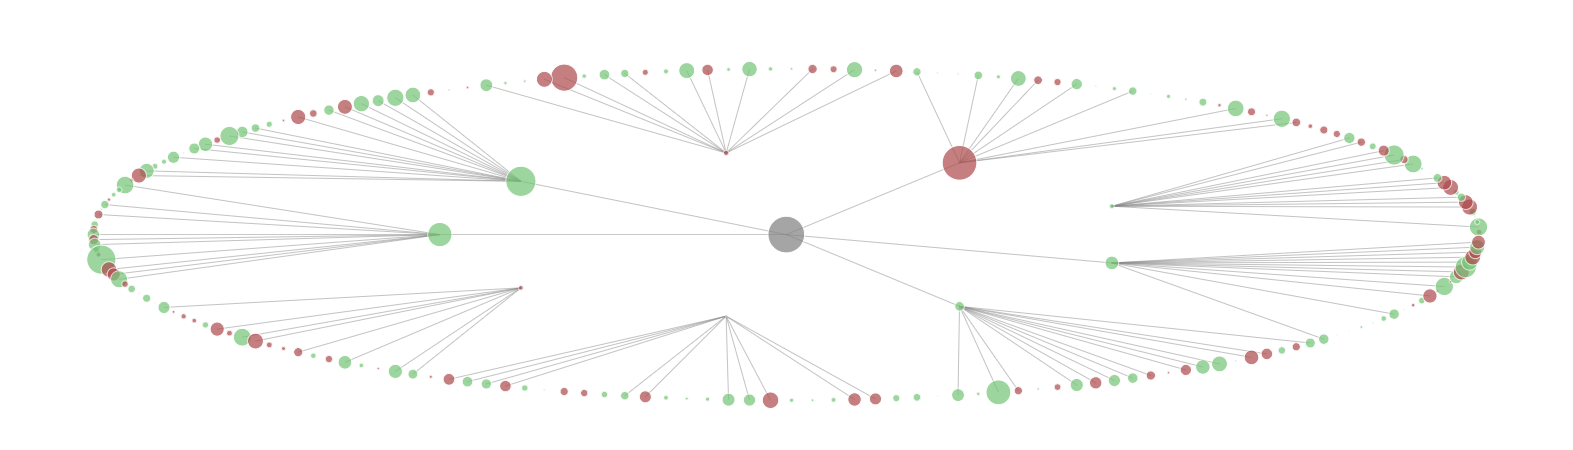

In [24]:

idx = 132
x_onehot = X_onehot_test.loc[idx].values
print(X_test.loc[idx])
prob = model.predict(np.array([x_onehot]))[0][0] 
class_idx = (prob > .5) * 1
class_name = class_names[class_idx]
feature_acts = features_func([np.array([x_onehot])])[0][0]
relevance_current_class = get_feature_to_output_relevance(x_onehot)
G = nx.DiGraph()
class_node = f'{CLASS}\n{class_name}'
G.add_node(class_node,  relevance = relevance_current_class.sum(), label = CLASS + ' = ' + class_name + "\n (prob = %.1f%%)" % (prob*100))
feature_acts_prime = generate_featprime(feature_acts)
pre_soft_prime = feature_extraction_model.predict(feature_acts_prime)
critical_supports_feature = ((pre_soft_prime > .5) * 1).flatten() != class_idx

for filter_idx in range(len(feature_acts)):
        if critical_supports_feature[filter_idx]:
            G.add_node(filter_idx, type = CRITICAL_SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]),  label = 'Hidden Neuron ' + str(filter_idx)+ "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(class_node, filter_idx,  type = CRITICAL_SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]))
        elif relevance_current_class[filter_idx] > 0:
            G.add_node(filter_idx, type = SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]), label = 'Hidden Neuron ' + str(filter_idx) + "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(class_node, filter_idx, type = SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]))
        elif relevance_current_class[filter_idx] < 0:
            G.add_node(filter_idx,  type = ATTACK, relevance = np.abs(relevance_current_class[filter_idx]),  label = 'Hidden Neuron ' + str(filter_idx)+ "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(class_node, filter_idx, type = ATTACK, relevance = np.abs(relevance_current_class[filter_idx]))
#         elif relevance_current_class[filter_idx] == 0:
#             G.add_node(filter_idx, relevance = np.abs(relevance_current_class[filter_idx]), level = 1)
#             G.add_edge(filter_idx, class_node, type = NEUTRAL, level = 1)

input_relevance = np.array(get_input_to_feature_relevance(x_onehot))

debug = False
for filter_idx in [node for node in G.nodes if G.nodes[node]][1:]:
    for c, col in enumerate(X_onehot.columns.values):
        label = f"{'_'.join(col.split('_')[:-1])} = {col.split('_')[-1]}"
        val = input_relevance[c,filter_idx] / np.abs(input_relevance[:,filter_idx]).sum()
        if input_relevance[c,filter_idx] > 0 and x_onehot[c] > 0:
            if debug:
                print(filter_idx,col,SUPPORT,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node((filter_idx,col) 
                       ,           type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx, (filter_idx,col)
                       , type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
        elif input_relevance[c,filter_idx] < 0 and x_onehot[c] > 0:
            if debug:
                print(filter_idx,col,ATTACK,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node((filter_idx,col)
                       ,           type = ATTACK, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx, (filter_idx,col)
                       , type = ATTACK, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
        elif input_relevance[c,filter_idx] > 0:
            if debug:
                print(filter_idx,col,NON_SUPPORT,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node((filter_idx,col)
                       ,           type = NON_SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx, (filter_idx,col)
                       , type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
        elif input_relevance[c,filter_idx] < 0:
            if debug:
                print(filter_idx,col,NON_ATTACK,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node((filter_idx,col)
                       ,           type = NON_ATTACK, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx, (filter_idx,col)
                       , type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["relevance"] > np.median([d["relevance"] for (u, v, d) in G.edges(data=True)])]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["relevance"] <= np.median([d["relevance"] for (u, v, d) in G.edges(data=True)])]
nlarge = [u for (u, v) in G.nodes(data=True) if v["relevance"] > np.median([d["relevance"] for (u, v, d) in G.edges(data=True)])]
nsmall = [u for (u, v) in G.nodes(data=True) if v["relevance"] <= np.median([d["relevance"] for (u, v, d) in G.edges(data=True)])]
print(len(elarge))
print(len(esmall))

# new_pos = nx.spring_layout(G)  # positions for all nodes

pos = hierarchy_pos(G, width = 2*math.pi, xcenter=0)
layout = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}


edge_x = []
edge_y = []
for e, edge in enumerate(elarge):
    x0, y0 = layout[list(elarge)[e][0]]
    x1, y1 = layout[list(elarge)[e][1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    
edge_color = [matplotlib.colors.rgb2hex(COLORS[G.edges[edge]['type']]) for edge in elarge]

import plotly.graph_objects as go

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    hoverinfo='none',
    mode='lines',
    line=dict(width=0.5, color='#888'))

node_x = []
node_y = []
for n, node in enumerate(G.nodes()):
    x, y = layout[list(G.nodes())[n]]
    node_x.append(x)
    node_y.append(y)

node_strengths = [G.nodes[node]['relevance'] for node in G.nodes]
node_size = 2000*np.abs(node_strengths) / np.sum(np.abs(node_strengths))
node_color = ['grey']+[matplotlib.colors.rgb2hex(COLORS[G.edges[edge]['type']]) for edge in G.edges]

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
#         showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
#         colorscale='YlGnBu',
#         reversescale=True,
        color=node_color,
        size=node_size,
#         colorbar=dict(
#             thickness=15,
#             title='Node Connections',
#             xanchor='left',
#             titleside='right'
#         ),
        line_width=1))

#### Adde labels
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(str(list(G.nodes)[node])+' : '+str([G.nodes[node]['relevance'] for node in G.nodes][node])
                     #'# of connections: '+str(len(adjacencies[1]))
                    )

# node_trace.marker.color = node_adjacencies
node_trace.text = node_text

#### Plot
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
#                 title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
#                 annotations=[ dict(
#                     text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
#                     showarrow=True,
#                     xref="paper", yref="paper",
#                     x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [34]:

idx = 132
x_onehot = X_onehot_test.loc[idx].values
print(X_test.loc[idx])
prob = model.predict(np.array([x_onehot]))[0][0] 
class_idx = (prob > .5) * 1
class_name = class_names[class_idx]
feature_acts = features_func([np.array([x_onehot])])[0][0]
relevance_current_class = get_feature_to_output_relevance(x_onehot)
G = nx.DiGraph()
class_node = f'{CLASS}\n{class_name}'
G.add_node(class_node,  relevance = relevance_current_class.sum(), label = CLASS + ' = ' + class_name + "\n (prob = %.1f%%)" % (prob*100))
feature_acts_prime = generate_featprime(feature_acts)
pre_soft_prime = feature_extraction_model.predict(feature_acts_prime)
critical_supports_feature = ((pre_soft_prime > .5) * 1).flatten() != class_idx

for filter_idx in range(len(feature_acts)):
        if critical_supports_feature[filter_idx]:
            G.add_node(filter_idx, type = CRITICAL_SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]),  label = 'Hidden Neuron ' + str(filter_idx)+ "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(class_node, filter_idx, weight = 10-np.abs(relevance_current_class[filter_idx]))
        elif relevance_current_class[filter_idx] > 0:
            G.add_node(filter_idx, type = SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]), label = 'Hidden Neuron ' + str(filter_idx) + "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(class_node, filter_idx, weight = 10-np.abs(relevance_current_class[filter_idx]))
        elif relevance_current_class[filter_idx] < 0:
            G.add_node(filter_idx,  type = ATTACK, relevance = np.abs(relevance_current_class[filter_idx]),  label = 'Hidden Neuron ' + str(filter_idx)+ "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
            G.add_edge(class_node, filter_idx, weight = 10-np.abs(relevance_current_class[filter_idx]))
#         elif relevance_current_class[filter_idx] == 0:
#             G.add_node(filter_idx, relevance = np.abs(relevance_current_class[filter_idx]), level = 1)
#             G.add_edge(filter_idx, class_node, type = NEUTRAL, level = 1)

input_relevance = np.array(get_input_to_feature_relevance(x_onehot))

debug = False
for filter_idx in [node for node in G.nodes if G.nodes[node]][1:]:
    for c, col in enumerate(X_onehot.columns.values):
        label = f"{'_'.join(col.split('_')[:-1])} = {col.split('_')[-1]}"
        val = input_relevance[c,filter_idx] / np.abs(input_relevance[:,filter_idx]).sum()
        if input_relevance[c,filter_idx] > 0 and x_onehot[c] > 0:
            if debug:
                print(filter_idx,col,SUPPORT,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node( col
                       ,           type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx,  col
                       , weight=10-np.abs( input_relevance[c,filter_idx])
                      )
        elif input_relevance[c,filter_idx] < 0 and x_onehot[c] > 0:
            if debug:
                print(filter_idx,col,ATTACK,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node( col
                       ,           type = ATTACK, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx,  col
                       , weight=10-np.abs( input_relevance[c,filter_idx])
                      )
        elif input_relevance[c,filter_idx] > 0:
            if debug:
                print(filter_idx,col,NON_SUPPORT,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node( col
                       ,           type = NON_SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx,  col
                       , weight=10-np.abs( input_relevance[c,filter_idx])
                      )
        elif input_relevance[c,filter_idx] < 0:
            if debug:
                print(filter_idx,col,NON_ATTACK,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
            G.add_node( col
                       ,           type = NON_ATTACK, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                      )
            G.add_edge(filter_idx,  col
                       , weight=10-np.abs( input_relevance[c,filter_idx])
                      )

ExternalRiskEstimate_bin                   (70.0, 75.0]
MSinceOldestTradeOpen_bin                 (91.0, 134.0]
MSinceMostRecentTradeOpen_bin               (0.0, 19.0]
AverageMInFile_bin                         (69.0, 96.0]
NumSatisfactoryTrades_bin                   (5.0, 12.0]
NumTrades60Ever2DerogPubRec_bin              (0.0, 1.0]
NumTrades90Ever2DerogPubRec_bin             (-7.0, 0.0]
NumTotalTrades_bin                           (0.0, 9.0]
NumTradesOpeninLast12M_bin                  (-7.0, 0.0]
PercentTradesNeverDelq_bin                 (84.0, 89.0]
MSinceMostRecentDelq_bin                    (0.0, 17.0]
MaxDelq2PublicRecLast12M_bin                 (5.0, 6.0]
MaxDelqEver_bin                              (2.0, inf]
PercentInstallTrades_bin                    (0.0, 35.0]
NetFractionInstallBurden_bin               (-9.0, -8.0]
NumInstallTradesWBalance_bin               (-9.0, -8.0]
MSinceMostRecentInqexcl7days_bin           (-8.0, -7.0]
NumInqLast6M_bin                            (-7.

In [26]:
G

In [27]:
[nx.dijkstra_path(G, 'RiskPerformance\nGood', node) for node in G.nodes]

[['RiskPerformance\nGood'],
 ['RiskPerformance\nGood', 0],
 ['RiskPerformance\nGood', 1],
 ['RiskPerformance\nGood', 2],
 ['RiskPerformance\nGood', 3],
 ['RiskPerformance\nGood', 4],
 ['RiskPerformance\nGood', 5],
 ['RiskPerformance\nGood', 6],
 ['RiskPerformance\nGood', 8],
 ['RiskPerformance\nGood', 9],
 ['RiskPerformance\nGood', 1, 'ExternalRiskEstimate_bin_(70.0, 75.0]'],
 ['RiskPerformance\nGood', 3, 'MSinceOldestTradeOpen_bin_(91.0, 134.0]'],
 ['RiskPerformance\nGood', 1, 'MSinceMostRecentTradeOpen_bin_(0.0, 19.0]'],
 ['RiskPerformance\nGood', 3, 'AverageMInFile_bin_(69.0, 96.0]'],
 ['RiskPerformance\nGood', 3, 'NumSatisfactoryTrades_bin_(5.0, 12.0]'],
 ['RiskPerformance\nGood', 1, 'NumTrades60Ever2DerogPubRec_bin_(0.0, 1.0]'],
 ['RiskPerformance\nGood', 3, 'NumTrades90Ever2DerogPubRec_bin_(-7.0, 0.0]'],
 ['RiskPerformance\nGood', 1, 'NumTotalTrades_bin_(0.0, 9.0]'],
 ['RiskPerformance\nGood', 3, 'NumTradesOpeninLast12M_bin_(-7.0, 0.0]'],
 ['RiskPerformance\nGood', 1, 'PercentTra

In [28]:
 nx.pagerank(G, alpha=0.9)

{'RiskPerformance\nGood': 0.02335933522281573,
 0: 0.02572236258929412,
 1: 0.025636109798243586,
 2: 0.025721285246012617,
 3: 0.0256491997509876,
 4: 0.02566648852851365,
 5: 0.025722932030708117,
 6: 0.025733420079212536,
 8: 0.025708600303586404,
 9: 0.025697296085318747,
 'ExternalRiskEstimate_bin_(70.0, 75.0]': 0.03242551381067953,
 'MSinceOldestTradeOpen_bin_(91.0, 134.0]': 0.03240476243778957,
 'MSinceMostRecentTradeOpen_bin_(0.0, 19.0]': 0.03240166390350564,
 'AverageMInFile_bin_(69.0, 96.0]': 0.03243567475935393,
 'NumSatisfactoryTrades_bin_(5.0, 12.0]': 0.03240759576891897,
 'NumTrades60Ever2DerogPubRec_bin_(0.0, 1.0]': 0.03240947642455693,
 'NumTrades90Ever2DerogPubRec_bin_(-7.0, 0.0]': 0.03243194082477471,
 'NumTotalTrades_bin_(0.0, 9.0]': 0.03242043692631107,
 'NumTradesOpeninLast12M_bin_(-7.0, 0.0]': 0.03242735159295676,
 'PercentTradesNeverDelq_bin_(84.0, 89.0]': 0.03241365584450898,
 'MSinceMostRecentDelq_bin_(0.0, 17.0]': 0.032380283715718494,
 'MaxDelq2PublicRecLast1

In [29]:
outputTensor = model.output
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(outputTensor, listOfVariableTensors)
trainingInputs = X_onehot
sess = K.get_session()
# sess = tf.InteractiveSession()
# sess.run(tf.initialize_all_variables())
evaluated_gradients = sess.run(gradients, feed_dict={model.input: trainingInputs})

In [30]:
evaluated_gradients[0]

array([[-6.29519348e+01,  5.46626816e+01,  7.77226944e+01, ...,
        -9.39736068e-02, -2.01788053e-01, -2.12835163e-01],
       [-4.32501297e+01,  1.52554245e+02,  2.11888763e+02, ...,
        -2.18955269e+01, -1.74381084e+01, -5.36022072e+01],
       [-1.18595108e+02,  2.04215698e+02,  2.51423523e+02, ...,
        -3.47959900e+01, -1.92296047e+01, -9.20198059e+01],
       ...,
       [-7.18878632e+01,  1.10421738e+02,  1.05401535e+02, ...,
        -3.20278625e+01, -1.97555885e+01, -5.50649261e+01],
       [-9.02953186e+01,  1.63045090e+02,  1.81426132e+02, ...,
        -2.60078564e+01, -2.02340374e+01, -8.15913925e+01],
       [-6.30840187e+01,  1.45955612e+02,  1.62228271e+02, ...,
        -2.18470078e+01, -1.76429214e+01, -5.72208824e+01]], dtype=float32)

In [31]:
evaluated_gradients[1]

array([-633.95715,  825.42816,  824.35596, -403.01303, -516.64417,
        346.61945,  160.07498, -174.45242, -106.99425, -390.06458],
      dtype=float32)

In [32]:
evaluated_gradients[2]

array([[ 742.1693 ],
       [2092.6423 ],
       [ 822.02545],
       [2242.2783 ],
       [ 808.60645],
       [ 814.40796],
       [ 616.5073 ],
       [ 577.1105 ],
       [ 165.56409],
       [1590.9886 ]], dtype=float32)

In [33]:
evaluated_gradients[3]

array([2164.728], dtype=float32)

In [ ]:
from tqdm import tqdm

# idx = 132
G = nx.DiGraph()
for idx in tqdm(range(len(X_train))):
    x_onehot = X_onehot_train.iloc[idx].values
#     print(idx)
    prob = model.predict(np.array([x_onehot]))[0][0] 
    class_idx = (prob > .5) * 1
    class_name = class_names[class_idx]
    feature_acts = features_func([np.array([x_onehot])])[0][0]
    relevance_current_class = get_feature_to_output_relevance(x_onehot)
    class_node = f'{CLASS}\n'
    G.add_node(class_node,  relevance = relevance_current_class.sum(), label = CLASS + ' = ' + class_name + "\n (prob = %.1f%%)" % (prob*100))
    feature_acts_prime = generate_featprime(feature_acts)
    pre_soft_prime = feature_extraction_model.predict(feature_acts_prime)
    critical_supports_feature = ((pre_soft_prime > .5) * 1).flatten() != class_idx

    for filter_idx in range(len(feature_acts)):
            if critical_supports_feature[filter_idx]:
                G.add_node(filter_idx, type = CRITICAL_SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]),  label = 'Hidden Neuron ' + str(filter_idx)+ "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
                G.add_edge(filter_idx, class_node,  weight = 10-np.abs(relevance_current_class[filter_idx]))
            elif relevance_current_class[filter_idx] > 0:
                G.add_node(filter_idx, type = SUPPORT, relevance = np.abs(relevance_current_class[filter_idx]), label = 'Hidden Neuron ' + str(filter_idx) + "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
                G.add_edge(filter_idx, class_node,  weight = 10-np.abs(relevance_current_class[filter_idx]))
            elif relevance_current_class[filter_idx] < 0:
                G.add_node(filter_idx,  type = ATTACK, relevance = np.abs(relevance_current_class[filter_idx]),  label = 'Hidden Neuron ' + str(filter_idx)+ "\n (R = %.2f)" % (relevance_current_class[filter_idx]))
                G.add_edge(filter_idx, class_node,  weight = 10-np.abs(relevance_current_class[filter_idx]))
    #         elif relevance_current_class[filter_idx] == 0:
    #             G.add_node(filter_idx, relevance = np.abs(relevance_current_class[filter_idx]), level = 1)
    #             G.add_edge(filter_idx, class_node, type = NEUTRAL, level = 1)

    input_relevance = np.array(get_input_to_feature_relevance(x_onehot))

    debug = False
    for filter_idx in range(sum(feature_acts>0)):
        for c, col in enumerate(X_onehot.columns.values):
            label = f"{'_'.join(col.split('_')[:-1])} = {col.split('_')[-1]}"
            val = input_relevance[c,filter_idx] / np.abs(input_relevance[:,filter_idx]).sum()
            if input_relevance[c,filter_idx] > 0 and x_onehot[c] > 0:
                if debug:
                    print(filter_idx,col,SUPPORT,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
                G.add_node( col
                           ,           type = SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                          )
                G.add_edge(  col, filter_idx
                           , weight=10-np.abs( input_relevance[c,filter_idx])
                          )
            elif input_relevance[c,filter_idx] < 0 and x_onehot[c] > 0:
                if debug:
                    print(filter_idx,col,ATTACK,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
                G.add_node( col
                           ,           type = ATTACK, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                          )
                G.add_edge(  col, filter_idx
                           , weight=10-np.abs( input_relevance[c,filter_idx])
                          )
            elif input_relevance[c,filter_idx] > 0:
                if debug:
                    print(filter_idx,col,NON_SUPPORT,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
                G.add_node( col
                           ,           type = NON_SUPPORT, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                          )
                G.add_edge(  col, filter_idx
                           , weight=10-np.abs( input_relevance[c,filter_idx])
                          )
            elif input_relevance[c,filter_idx] < 0:
                if debug:
                    print(filter_idx,col,NON_ATTACK,val,input_relevance[c,filter_idx],input_relevance[:,filter_idx].sum(),np.abs(relevance_current_class[filter_idx]))
                G.add_node( col
                           ,           type = NON_ATTACK, relevance = np.abs( input_relevance[c,filter_idx]), label = label
                          )
                G.add_edge(  col, filter_idx
                           , weight=10-np.abs( input_relevance[c,filter_idx])
                          )

  0%|                                                                                         | 0/7844 [00:00<?, ?it/s]C:\Users\brizio\Anaconda3\envs\gnet\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

invalid value encountered in float_scalars

 55%|██████████████████████████████████████████▋                                   | 4296/7844 [01:29<01:20, 43.81it/s]

In [39]:
G

In [91]:
my_dict = nx.pagerank_numpy(G)
my_dict.update((x, round(y*100,3)) for x, y in my_dict.items())
sorted(my_dict.items(), key=lambda x:x[1], reverse=True)

[(0, 0.654),
 (3, 0.654),
 (6, 0.654),
 (7, 0.654),
 (8, 0.654),
 (5, 0.654),
 (9, 0.653),
 (4, 0.652),
 (1, 0.652),
 (2, 0.652),
 ('ExternalRiskEstimate_bin_(80.0, inf]', 0.646),
 ('MSinceOldestTradeOpen_bin_(134.0, 263.0]', 0.646),
 ('MSinceMostRecentTradeOpen_bin_(19.0, inf]', 0.646),
 ('AverageMInFile_bin_(69.0, 96.0]', 0.646),
 ('NumSatisfactoryTrades_bin_(5.0, 12.0]', 0.646),
 ('NumTrades60Ever2DerogPubRec_bin_(-7.0, 0.0]', 0.646),
 ('NumTrades90Ever2DerogPubRec_bin_(-7.0, 0.0]', 0.646),
 ('NumTotalTrades_bin_(9.0, 16.0]', 0.646),
 ('NumTradesOpeninLast12M_bin_(-7.0, 0.0]', 0.646),
 ('PercentTradesNeverDelq_bin_(96.0, inf]', 0.646),
 ('MSinceMostRecentDelq_bin_(-8.0, -7.0]', 0.646),
 ('MaxDelq2PublicRecLast12M_bin_(6.0, inf]', 0.646),
 ('MaxDelqEver_bin_(2.0, inf]', 0.646),
 ('PercentInstallTrades_bin_(57.0, 84.0]', 0.646),
 ('NetFractionInstallBurden_bin_(0.0, 35.0]', 0.646),
 ('NumInstallTradesWBalance_bin_(3.0, 11.0]', 0.646),
 ('MSinceMostRecentInqexcl7days_bin_(-8.0, -7.0]',